In [3]:
import requests
import time
import json
import os
import yaml
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy.types import Integer
from matplotlib import pyplot as plt

config = yaml.safe_load(open('config.yaml'))
db_username = config['mysql']['username']
db_password = config['mysql']['password']
db_endpoint = config['mysql']['endpoint']
db_database = config['mysql']['database']
engine = create_engine('mysql+pymysql://{}:{}@{}/{}?charset=utf8mb4'.format(db_username, db_password, db_endpoint, db_database))


In [7]:
price_distribution = pd.read_sql_query(
        '''
SELECT distinct initial_price, PERCENT_RANK() OVER (order by initial_price) as percentage FROM steam.steam_app_details 
where initial_price is not null
and currency = 'USD'
;
        ''', engine)

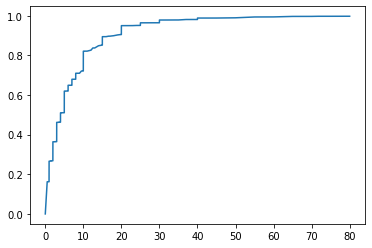

In [12]:
price_distribution_plot = price_distribution.loc[(price_distribution.initial_price < 80)]
plt.plot(price_distribution_plot['initial_price'], price_distribution_plot['percentage'])

In [13]:
cat_distribution = pd.read_sql_query(
'''
SELECT  result, count(*)
  FROM  (
        SELECT  SUBSTRING_INDEX(SUBSTRING_INDEX(categories, ',', a.letter + 1), ',', -1) result
          FROM  steam.steam_app_details
            INNER JOIN (SELECT 0 letter UNION ALL SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3) a ON LENGTH(REPLACE(categories, ',' , '')) <= LENGTH(categories) - a.letter
        ) a
  GROUP BY result
''', engine)

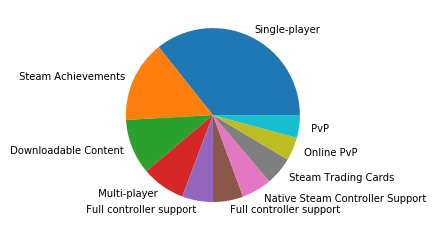

In [22]:
cat_distribution_plot = cat_distribution.nlargest(10, 'count(*)')
patches,text1 = plt.pie(cat_distribution_plot['count(*)'], labels = cat_distribution_plot['result'])
plt.show()

In [23]:
populate_game = pd.read_sql_query(
'''
select a.name,c.custs
from (
SELECT app_id, count(distinct user_id) as custs from steam.steam_owned_games group by 1
) c
join steam.steam_app_details a on a.app_id = c.app_id
''', engine)

In [24]:
populate_game.nlargest(10,'custs')

,name,custs
27,Counter-Strike: Global Offensive,2490
1346,Unturned,2079
55,Garry's Mod,1978
21,Team Fortress 2,1910
24,Dota 2,1667
23,Left 4 Dead 2,1580
2860,Z1 Battle Royale,1332
1331,Trove,1146
25,Portal 2,1066
1518,Don't Starve Together,1020


In [25]:
longplay_game = pd.read_sql_query(
'''
select a.name,c.playtime
from (
SELECT app_id, sum(playtime_forever) as playtime from steam.steam_owned_games group by 1
) c
join steam.steam_app_details a on a.app_id = c.app_id
''', engine)

In [26]:
longplay_game.nlargest(10,'playtime')

,name,playtime
27,Counter-Strike: Global Offensive,155821014.0
24,Dota 2,65338317.0
55,Garry's Mod,34116811.0
21,Team Fortress 2,13406012.0
1807,ARK: Survival Evolved,10055071.0
2294,Dead by Daylight,8473418.0
2860,Z1 Battle Royale,6930520.0
1346,Unturned,6120412.0
860,SteamVR,4783993.0
619,DayZ,4729263.0
